# Deep Learning: Practice 1 CNNs
## Aitana Martínez Rey




### Part 1: Custom CNNs

### 1.1 Exploring the dataset

The CIFAR-100 dataset is a collection of 60,000 color images (32x32 pixels) divided into 100 classes, with 600 images per class.
Each image belongs to one of 20 superclasses, grouping similar categories together. We will try to classify these superclasses.
The dataset is split into 50,000 training images and 10,000 test images.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import regularizers
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras import models
from keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [3]:
# Import dataset and load dataset
## In this case we are user label_mode = 'coarse', because we are going to try to classify in the 20 different superclasses
(train_x, train_y), (test_x, test_y) = keras.datasets.cifar100.load_data(label_mode="coarse")

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [4]:
# Summarize dataset shapes
print("train_x shape:", train_x.shape)
print("train_y shape:", train_y.shape)
print("test_x shape:", test_x.shape)
print("test_y shape:", test_y.shape)

train_x shape: (50000, 32, 32, 3)
train_y shape: (50000, 1)
test_x shape: (10000, 32, 32, 3)
test_y shape: (10000, 1)


In [5]:
# Data format
print(type(train_x))
print(type(train_y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [9]:
# We are going to map the label names to the class
coarse_label_names = [
    "aquatic mammals", "fish", "flowers", "food containers", "fruit and vegetables",
    "household electrical devices", "household furniture", "insects", "large carnivores",
    "large man-made outdoor things", "large natural outdoor scenes", "large omnivores and herbivores",
    "medium-sized mammals", "non-insect invertebrates", "people", "reptiles",
    "small mammals", "trees", "vehicles 1", "vehicles 2"
]

coarse_label_dict = {i: name for i, name in enumerate(coarse_label_names)}

# For example class 4 now belongs to fruit and vegetables superclass
label = 4
print(f"Class number: {label}, Superclass: {coarse_label_dict[label]}")



Class number: 4, Superclass: fruit and vegetables


We can show randomly some images in the CIFAR-100 dataset as an example

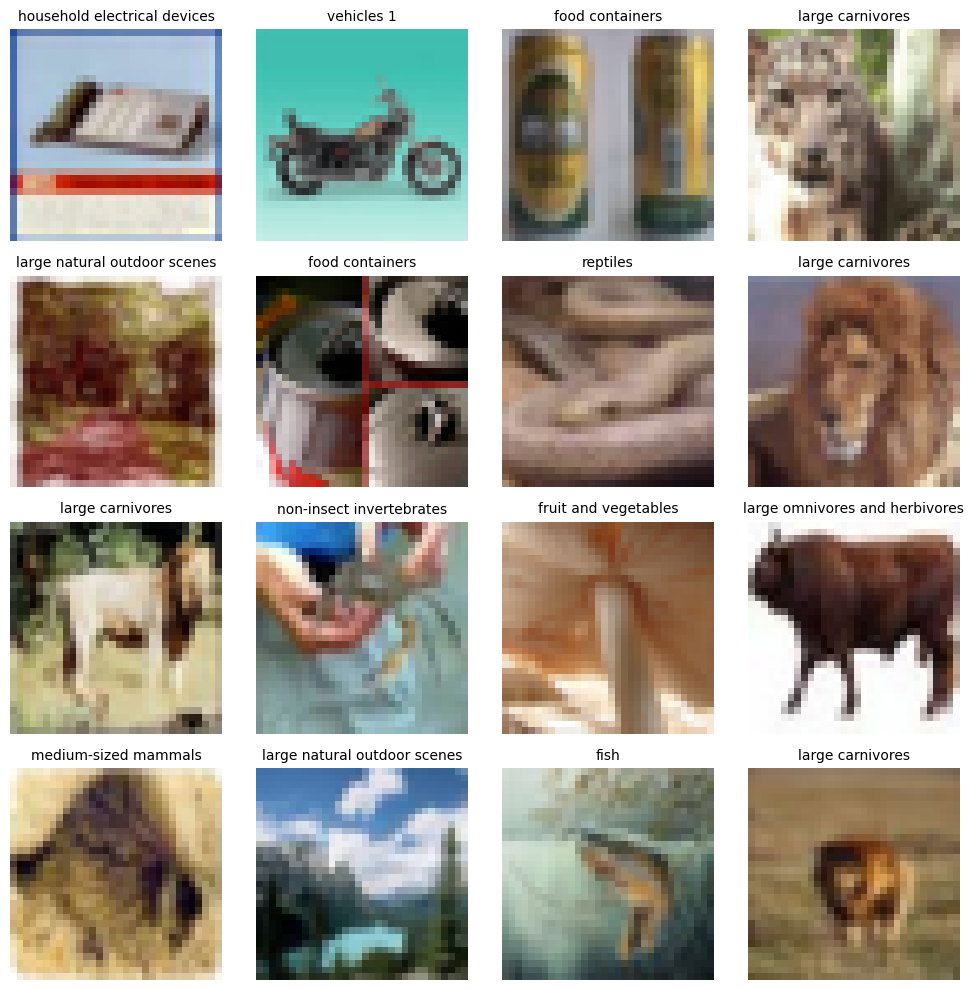

In [10]:
plt.figure(figsize=(10, 10))
for i in range(16):
    rand_num = np.random.randint(0, len(train_x))
    plt.subplot(4, 4, i+1)
    plt.imshow(train_x[rand_num])
    plt.title(coarse_label_dict[train_y[rand_num][0]], fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()



### 1.2 Data preprocessing

In [6]:
# First of all we will reshape images
train_x = train_x.reshape(-1, 32,32,3)
test_x = test_x.reshape(-1, 32,32,3)


In [7]:
# Normalize the image data to a range of 0 to 1
train_x = train_x.astype('float32') / 255.0
test_x = test_x.astype('float32') / 255.0
print('train: x=%s, y=%s' % (train_x.shape, train_y.shape))
print('test: x=%s, y=%s' % (test_x.shape, test_y.shape))



train: x=(50000, 32, 32, 3), y=(50000, 1)
test: x=(10000, 32, 32, 3), y=(10000, 1)


In [8]:
# Convert class labels to one-hot encoding
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)
# Print the shapes of the preprocessed data
print("Training data shape:", train_x.shape)
print("Training labels shape:", train_y.shape)
print("Testing data shape:", test_x.shape)
print("Testing labels shape:", test_y.shape)



Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 20)
Testing data shape: (10000, 32, 32, 3)
Testing labels shape: (10000, 20)


Now we should create a validation dataset from the training dataset for hyperparameter tuning

In [9]:

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# We repeat the preprocessing process for this new dataset
val_x = val_x.reshape(-1, 32,32,3)
val_x = val_x.astype('float32') / 255.0
train_x = train_x.reshape(-1, 32,32,3)
test_x = test_x.reshape(-1, 32,32,3)
# Normalize the image data to a range of 0 to 1
train_x = train_x.astype('float32') / 255.0
test_x = test_x.astype('float32') / 255.0


# Show dimensions
print(f"Training dimensions: {train_x.shape}, {train_y.shape}")
print(f"Validation dimensions: {val_x.shape}, {val_y.shape}")


Training dimensions: (40000, 32, 32, 3), (40000, 20)
Validation dimensions: (10000, 32, 32, 3), (10000, 20)


## 1.3 Model approaches

As we are not aware of the best hyperparameters for this specific dataset, I'm going to start off from a **simple CNN arquitecture** and develope different experiments showing benefits of:



*   Increasing number of filters in convolution layers.
*   Increasing number of convolution layers.
*   Taking advantages of Dropout layers.
*   Taking advantages of Batch normalization layers
*   Exploring l2 regularization
.

### 1.3.1 Baseline Model

We will use as a baseline model a 3 convolutional layers model

In [12]:
base_model = models.Sequential()
base_model.add(layers.Input(shape=(32,32, 3)))

base_model.add(layers.Conv2D(256, (3,3), activation='relu'))
base_model.add(layers.MaxPooling2D(2,2))

base_model.add(layers.Conv2D(128, (3,3), activation='relu'))
base_model.add(layers.MaxPooling2D(2,2))

base_model.add(layers.Conv2D(64, (3,3), activation='relu'))
base_model.add(layers.MaxPooling2D(2,2))


base_model.add(layers.Flatten())

base_model.add(layers.Dense(64, activation='relu'))

base_model.add(layers.Dense(20, activation='softmax'))

base_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 256)         │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 393,748 (1.50 MB)

 Trainable params: 393,748 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Let's compile the model
base_model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [14]:
# Train the model
base_history = base_model.fit(train_x,
                    train_y,
                    epochs = 10,
                    batch_size = 32,
                    validation_data = (val_x, val_y))

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.0486 - loss: 2.9961 - val_accuracy: 0.0494 - val_loss: 2.9960
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0509 - loss: 2.9960 - val_accuracy: 0.0460 - val_loss: 2.9960
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0500 - loss: 2.9959 - val_accuracy: 0.0478 - val_loss: 2.9960
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0486 - loss: 2.9959 - val_accuracy: 0.0478 - val_loss: 2.9961
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0508 - loss: 2.9958 - val_accuracy: 0.0502 - val_loss: 2.9960
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0467 - loss: 2.9960 - val_accuracy: 0.0482 - val_loss: 2.9961
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0473 - loss: 2.9959 - val_accuracy: 0.0460 - val_loss: 2.9962
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0519 - loss: 2.9958 -

As we can see, this model is insufficient for this problem, we must apply model regularization and develope a more complex arquitecture, including exploring new configurations and tuning.

### 1.3.2 Model development and regularization

In our case, we used Keras Tuner (see Helper functions section) to help design a complex Convolutional Neural Network (CNN). We added more depth to our model, batch normalization layers, dropout layers to stop overfitting and l2 regularizers, that are the ones that fit best our model. After different tests, this is the best regularized model we've found.
In this case, al values are settled in an average dropout (0.3), l2 (0.0003), kernel size (3)....but they will be redefined in the next tests.

In [58]:
model = keras.Sequential()
model.add(layers.Input(shape=(32,32, 3)))


model.add(layers.Conv2D(512, kernel_size=3, activation='relu', padding='same',
                        kernel_regularizer=regularizers.l2(0.0003)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, kernel_size=3, activation='relu', padding='same',
                        kernel_regularizer=regularizers.l2(0.0003)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, kernel_size=3, activation='relu', padding='same',
                        kernel_regularizer=regularizers.l2(0.0003)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, kernel_size=3, activation='relu', padding='same',
                        kernel_regularizer=regularizers.l2(0.0003)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(32, kernel_size=3, activation='relu', padding='same',
                        kernel_regularizer=regularizers.l2(0.0003)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0003)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0003)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(20, activation='softmax'))

In [55]:
model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss="categorical_crossentropy",
        metrics=["accuracy"])

model.summary()
history = model.fit(train_x, train_y,
                    epochs=30,
                    validation_data=(val_x, val_y))

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)                   │ (None, 32, 32, 512)         │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 32, 32, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 32, 32, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 8, 8, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 8, 8, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 512)                 │           2,0

 Total params: 1,918,964 (7.32 MB)

 Trainable params: 1,915,700 (7.31 MB)

 Non-trainable params: 3,264 (12.75 KB)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - accuracy: 0.1419 - loss: 3.5208 - val_accuracy: 0.2525 - val_loss: 2.8075
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.2662 - loss: 2.7732 - val_accuracy: 0.3399 - val_loss: 2.4511
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.3370 - loss: 2.4834 - val_accuracy: 0.3378 - val_loss: 2.4221
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.3930 - loss: 2.2485 - val_accuracy: 0.3777 - val_loss: 2.2451
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.4388 - loss: 2.0865 - val_accuracy: 0.4078 - val_loss: 2.2031
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.4673 - loss: 1.9908 - val_accuracy: 0.4665 - val_loss: 2.0057
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.4938 - loss: 1.9072 - val_accuracy: 0.4633 - val_loss: 2.0128
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.5128 -

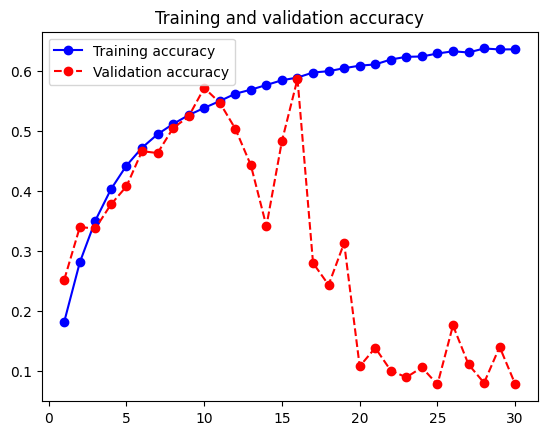

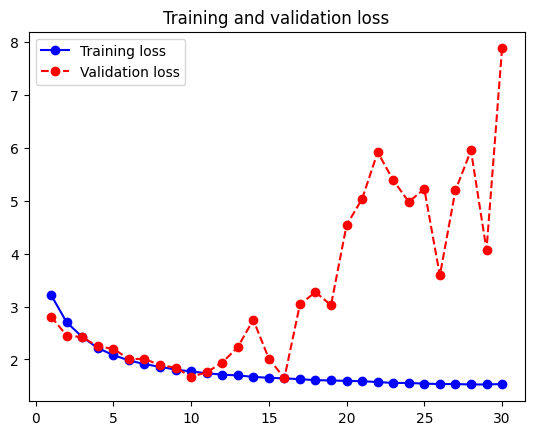

In [56]:
plot(history)

This results are much better, but there is some overfitting from the epoch 15 to the end. Before some manual tuning, we are going to implement some callbacks: EarlyStopping and ReduceLROnPlateau, to stop the training process before the model starts overfitting, and to dynamically adjust the learning rate during training to improve convergence.

### 1.3.3 Implementing callbacks and manual tuning

by adapting the number of units, searching for the best layers, and optimizing other parameters. Additionally, we performed some manual fine-tuning to further refine the model. More details about these experiments and their results are provided in the following sections.

In [17]:
model = keras.Sequential()
model.add(layers.Input(shape=(32,32, 3)))

model.add(layers.Conv2D(256, kernel_size=5, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.0002)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, kernel_size=3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.0002)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, kernel_size=3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.0003)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(64, kernel_size=3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.0003)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(32, kernel_size=3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.0004)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0002)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0003)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(20, activation='softmax'))

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 256)         │          19,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 512)                 │           2,0

 Total params: 1,333,236 (5.09 MB)

 Trainable params: 1,330,484 (5.08 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [61]:
model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.0005),
  loss="categorical_crossentropy",
  metrics=["accuracy"]
)



## CALLBACKS
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history1 = model.fit(train_x, train_y,
                    epochs=30,
                    validation_data=(val_x, val_y),
                    callbacks=[lr_scheduler, early_stopping])


Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - accuracy: 0.0992 - loss: 3.8608 - val_accuracy: 0.2263 - val_loss: 2.8044 - learning_rate: 5.0000e-04
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.1851 - loss: 2.9660 - val_accuracy: 0.2723 - val_loss: 2.6300 - learning_rate: 5.0000e-04
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.2408 - loss: 2.7391 - val_accuracy: 0.2744 - val_loss: 2.5698 - learning_rate: 5.0000e-04
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.2899 - loss: 2.5689 - val_accuracy: 0.2947 - val_loss: 2.4958 - learning_rate: 5.0000e-04
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.3249 - loss: 2.4271 - val_accuracy: 0.3775 - val_loss: 2.2071 - learning_rate: 5.0000e-04
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.3577 - loss: 2.3022 - val_accuracy: 0.4023 - val_loss: 2.1285 - learning_rate: 5.0000e-04
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━

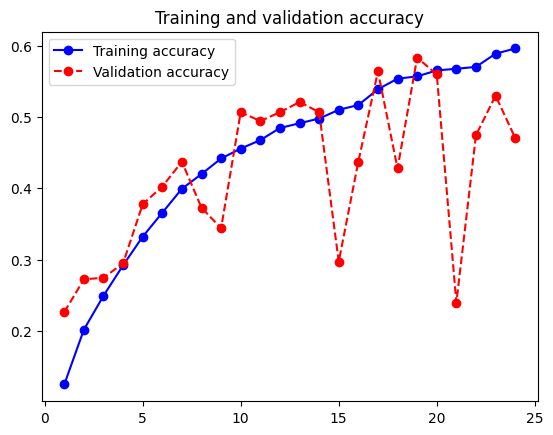

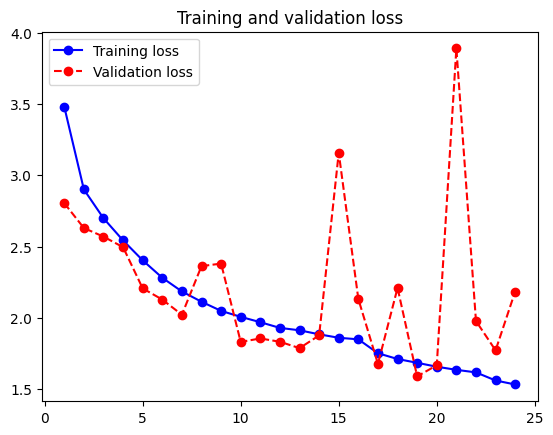

In [67]:
plot(history1)


From the top graph (accuracy), we can see that:

The training accuracy (blue line) steadily increases, indicating that the model is learning the training set effectively.
The validation accuracy (red line) fluctuates considerably, suggesting that the model struggles to generalize consistently. This behavior often points to overfitting, where the model memorizes the training data rather than learning generalizable features.
In the bottom graph (loss):

The training loss (blue line) decreases smoothly over epochs, confirming that the model is fitting the training data well.
The validation loss (red line) shows large spikes and volatility, another sign that the model may be overfitting and not adapting well to unseen data.

### 1.4 Model tests

We optimized regularization using both manual tuning and automated tuning (Keras Tuner) to reduce overfitting. Manually, we increased dropout rates (from 0.3 to 0.5 in deeper layers) and adjusted L2 regularization (lower in early layers, higher in later layers) to prevent co-adaptation and large weight values. Automatically, Keras Tuner searched for optimal L2 values, dropout rates, and filter sizes, balancing model complexity and generalization.

We made three different tests: a less deeper one, a more deeper one and the deepest.

#### Test 1: Less deeper model

In [14]:

model = keras.Sequential()

model.add(layers.Input(shape=(32, 32, 3)))

model.add(layers.Conv2D(256, kernel_size=5, activation='relu', padding='same',
                         kernel_regularizer=regularizers.l2(0.0002)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, kernel_size=3, activation='relu', padding='same',
                         kernel_regularizer=regularizers.l2(0.0002)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, kernel_size=3, activation='relu', padding='same',
                         kernel_regularizer=regularizers.l2(0.0003)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))


model.add(layers.Conv2D(32, kernel_size=3, activation='relu', padding='same',
                         kernel_regularizer=regularizers.l2(0.0004)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))


model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0002)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(20, activation='softmax'))

model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 256)         │          19,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 32)            │          36,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 8, 8, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │          10,2

 Total params: 1,219,124 (4.65 MB)

 Trainable params: 1,216,756 (4.64 MB)

 Non-trainable params: 2,368 (9.25 KB)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.1276 - loss: 3.7247 - val_accuracy: 0.2590 - val_loss: 2.7194 - learning_rate: 5.0000e-04
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.2391 - loss: 2.7798 - val_accuracy: 0.2989 - val_loss: 2.4721 - learning_rate: 5.0000e-04
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.2909 - loss: 2.5280 - val_accuracy: 0.3651 - val_loss: 2.2270 - learning_rate: 5.0000e-04
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.3312 - loss: 2.3615 - val_accuracy: 0.3967 - val_loss: 2.1432 - learning_rate: 5.0000e-04
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.3727 - loss: 2.2218 - val_accuracy: 0.3983 - val_loss: 2.1336 - learning_rate: 5.0000e-04
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.4008 - loss: 2.1132 - val_accuracy: 0.4605 - val_loss: 1.9336 - learning_rate: 5.0000e-04
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━

[1.311787486076355, 0.6388999819755554]

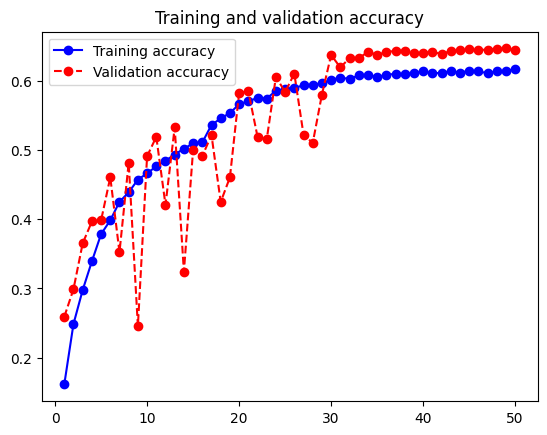

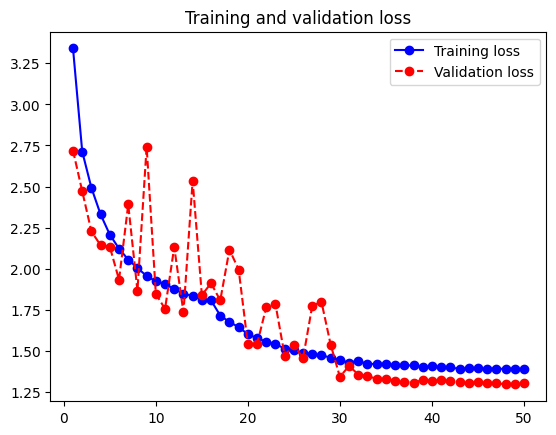

In [15]:
model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.0005),
  loss="categorical_crossentropy",
  metrics=["accuracy"]
)



## CALLBACKS
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_x, train_y,
                    epochs=50,
                    batch_size = 32,
                    validation_data=(val_x, val_y),
                    callbacks=[lr_scheduler, early_stopping])

plot(history)
model.evaluate(test_x, test_y)

#### Test 2: Finding the best model

In [21]:
model = keras.Sequential()
model.add(layers.Input(shape=(32,32, 3)))
model.add(layers.Conv2D(512, kernel_size=5, activation='relu', padding='same',
                        kernel_regularizer=regularizers.l2(0.0002)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, kernel_size=3, activation='relu', padding='same',
                        kernel_regularizer=regularizers.l2(0.0002)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))  # Aumentado para combatir overfitting

model.add(layers.Conv2D(128, kernel_size=3, activation='relu', padding='same',
                        kernel_regularizer=regularizers.l2(0.0003)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))  # Aumentado

model.add(layers.Conv2D(64, kernel_size=3, activation='relu', padding='same',
                        kernel_regularizer=regularizers.l2(0.0003)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(32, kernel_size=3, activation='relu', padding='same',
                        kernel_regularizer=regularizers.l2(0.0004)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))  # Más dropout en la última convolucional

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0002)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))  # Aumentado

model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0003)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))  # Aumentado

model.add(layers.Dense(20, activation='softmax'))
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)                   │ (None, 32, 32, 512)         │          38,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 32, 32, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 32, 32, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 8, 8, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 8, 8, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 512)                 │           2,0

 Total params: 1,943,540 (7.41 MB)

 Trainable params: 1,940,276 (7.40 MB)

 Non-trainable params: 3,264 (12.75 KB)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - accuracy: 0.0977 - loss: 3.9168 - val_accuracy: 0.2151 - val_loss: 2.8425 - learning_rate: 5.0000e-04
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.1802 - loss: 3.0056 - val_accuracy: 0.2236 - val_loss: 2.7362 - learning_rate: 5.0000e-04
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.2321 - loss: 2.7593 - val_accuracy: 0.2882 - val_loss: 2.5403 - learning_rate: 5.0000e-04
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.2771 - loss: 2.6054 - val_accuracy: 0.3178 - val_loss: 2.4398 - learning_rate: 5.0000e-04
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.3165 - loss: 2.4649 - val_accuracy: 0.3178 - val_loss: 2.4262 - learning_rate: 5.0000e-04
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.3492 - loss: 2.3394 - val_accuracy: 0.4134 - val_loss: 2.1041 - learning_rate: 5.0000e-04
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━

[1.2709192037582397, 0.6622999906539917]

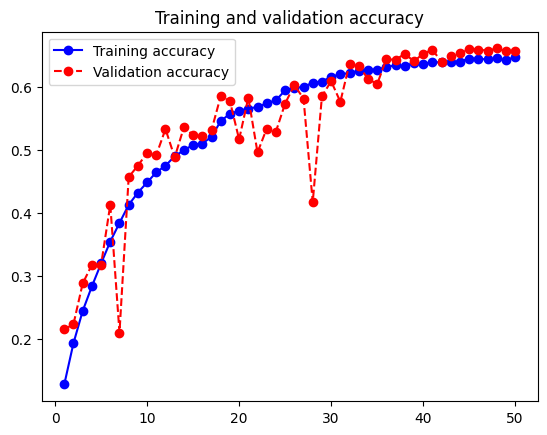

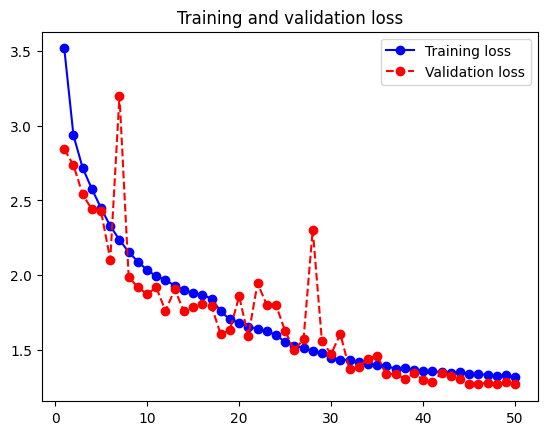

In [17]:
model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.0005),
  loss="categorical_crossentropy",
  metrics=["accuracy"]
)



## CALLBACKS
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_x, train_y,
                    epochs=50,
                    batch_size = 32,
                    validation_data=(val_x, val_y),
                    callbacks=[lr_scheduler, early_stopping])

plot(history)
model.evaluate(test_x, test_y)

#### Test 3: Can we go deeper?

In [ ]:
model = keras.Sequential()
model.add(layers.Input(shape=(32, 32, 3)))

# Increased number of convolutional layers to capture more complex features
model.add(layers.Conv2D(256, kernel_size=5, activation='relu', padding='same',
                         kernel_regularizer=regularizers.l2(0.0002)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, kernel_size=3, activation='relu', padding='same',
                         kernel_regularizer=regularizers.l2(0.0002)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, kernel_size=3, activation='relu', padding='same',
                         kernel_regularizer=regularizers.l2(0.0003)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, kernel_size=3, activation='relu', padding='same',
                         kernel_regularizer=regularizers.l2(0.0003)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(64, kernel_size=3, activation='relu', padding='same',
                         kernel_regularizer=regularizers.l2(0.0003)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, kernel_size=3, activation='relu', padding='same',
                         kernel_regularizer=regularizers.l2(0.0003)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())

# Increased number of dense layers to enhance generalization
model.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.0002)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0002)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0003)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0003)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(20, activation='softmax'))  

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (None, 32, 32, 256)         │          19,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,915,348 (11.12 MB)

 Trainable params: 2,909,716 (11.10 MB)

 Non-trainable params: 5,632 (22.00 KB)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - accuracy: 0.0719 - loss: 4.4284 - val_accuracy: 0.1882 - val_loss: 3.3096 - learning_rate: 5.0000e-04
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.1490 - loss: 3.4571 - val_accuracy: 0.1998 - val_loss: 3.2165 - learning_rate: 5.0000e-04
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.1936 - loss: 3.2298 - val_accuracy: 0.2620 - val_loss: 2.9608 - learning_rate: 5.0000e-04
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.2451 - loss: 3.0273 - val_accuracy: 0.2804 - val_loss: 2.8362 - learning_rate: 5.0000e-04
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.2894 - loss: 2.8253 - val_accuracy: 0.3622 - val_loss: 2.5408 - learning_rate: 5.0000e-04
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.3293 - loss: 2.6569 - val_accuracy: 0.3837 - val_loss: 2.4434 - learning_rate: 5.0000e-04
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━

[1.368617057800293, 0.6833999752998352]

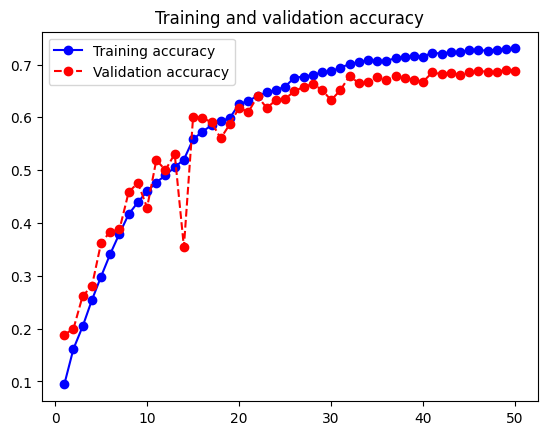

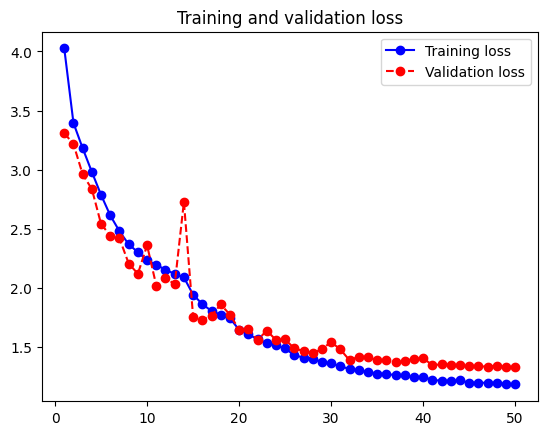

In [20]:
model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.0005),
  loss="categorical_crossentropy",
  metrics=["accuracy"]
)



## CALLBACKS
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_x, train_y,
                    epochs=50,
                    batch_size = 32,
                    validation_data=(val_x, val_y),
                    callbacks=[lr_scheduler, early_stopping])

plot(history)
model.evaluate(test_x, test_y)

##### Conclusions

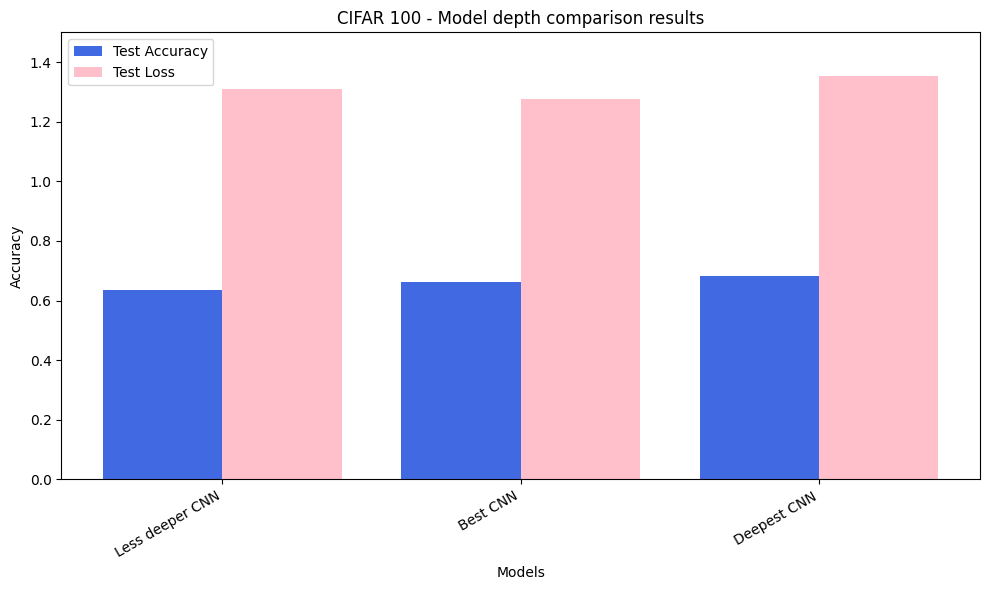

In [28]:
# Model names
models = [
    "Less deeper CNN",
    "Best CNN",
    "Deepest CNN",
]

# Test accuracies for each model
test_accuracies = [0.6353, 0.6613, 0.6833]
test_loss = [1.3087, 1.2749, 1.3522]


x = np.arange(len(models))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, test_accuracies, width, label="Test Accuracy", color="royalblue")
ax.bar(x + width/2, test_loss, width, label="Test Loss", color="pink")
ax.set_xlabel("Models")
ax.set_ylabel("Accuracy")
ax.set_title("CIFAR 100 - Model depth comparison results")
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=30, ha="right")
ax.set_ylim(0, 1.5)
ax.legend()

plt.tight_layout()
plt.show()


While the deepest model gets the best accuracy (0.6833), we can see that there is several overfitting. The same as the simplest model. Also the loss values are higher in these two. For these reasons, we will choose as our model the second one, which has the next structure:

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


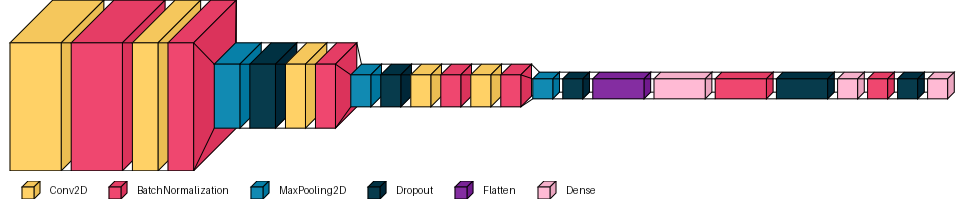

In [24]:
import visualkeras
from tensorflow import keras
visualkeras.layered_view(model, legend=True)  # Show model structure

## Comparing optimizers

We should try manually another optimizer in case this could work better

#### New optimizer: RMSprop

In [25]:
model.compile(
  optimizer=keras.optimizers.RMSprop(learning_rate=0.0005),
  loss="categorical_crossentropy",
  metrics=["accuracy"]
)


## CALLBACKS
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history3 = model.fit(train_x, train_y,
                    epochs=50,
                    validation_data=(val_x, val_y),
                    callbacks=[lr_scheduler, early_stopping])

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 21ms/step - accuracy: 0.6259 - loss: 1.4336 - val_accuracy: 0.6281 - val_loss: 1.4216 - learning_rate: 5.0000e-04
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.6007 - loss: 1.5417 - val_accuracy: 0.5576 - val_loss: 1.6758 - learning_rate: 5.0000e-04
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.5986 - loss: 1.5693 - val_accuracy: 0.6042 - val_loss: 1.5456 - learning_rate: 5.0000e-04
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.6269 - loss: 1.4886 - val_accuracy: 0.6488 - val_loss: 1.3846 - learning_rate: 2.5000e-04
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.6358 - loss: 1.4570 - val_accuracy: 0.6546 - val_loss: 1.3668 - learning_rate: 2.5000e-04
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.6393 - loss: 1.4386 - val_accuracy: 0.6509 - val_loss: 1.3833 - learning_rate: 2.5000e-04
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6979 - loss: 1.2049


[1.2058618068695068, 0.6944000124931335]

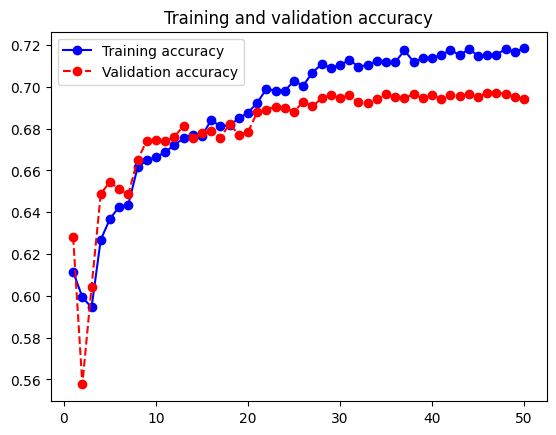

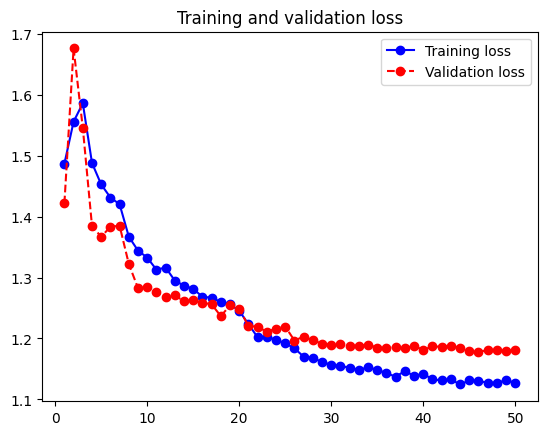

In [26]:
plot(history3)
model.evaluate(test_x, test_y)

##### Conclusions

While the model compiled with Adam got a test accuracy value of 0.6613, this one gets aproximately 0.6945. The problem is the same as with the deepest model, there is some overfitting over the last epochs. So in this case, we are going to stick to our previous optimizer (Adam).

### 1.3.5 Testing new arquitectures

#### Residual connections

In [93]:
def residual_block(x, filters, kernel_size, regularizer):

    residual = x

    x = layers.Conv2D(filters, kernel_size, activation='relu', padding='same',
                      kernel_regularizer=regularizer)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters, kernel_size, activation='relu', padding='same',
                      kernel_regularizer=regularizer)(x)
    x = layers.BatchNormalization()(x)

    if residual.shape[-1] != x.shape[-1]:
        residual = layers.Conv2D(filters, kernel_size=1, padding='same')(residual)

    x = layers.add([x, residual])

    return x


input_layer = layers.Input(shape=(32,32, 3))

x = layers.Conv2D(512, kernel_size=5, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.0002))(input_layer)
x = layers.BatchNormalization()(x)
x = residual_block(x, 512, kernel_size=5, regularizer=regularizers.l2(0.0002))


x = layers.Conv2D(256, kernel_size=3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.0002))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)


x = residual_block(x, 128, kernel_size=3, regularizer=regularizers.l2(0.0003))
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.4)(x)

x = residual_block(x, 64, kernel_size=3, regularizer=regularizers.l2(0.0003))

x = residual_block(x, 32, kernel_size=3, regularizer=regularizers.l2(0.0004))
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)

x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0002))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0003))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)


output_layer = layers.Dense(20, activation='softmax')(x)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model.summary()




Model: "functional_317"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_47            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_158 (Conv2D)       │ (None, 32, 32, 512)    │         38,912 │ input_layer_47[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_197   │ (None, 32, 32, 512)    │          2,048 │ conv2d_158[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_159 (Conv2D)       │ (None, 32, 32, 512)    │      6,554,112 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_198   │ (None, 32, 32, 512)    │          2,048 │ conv2d_159[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_160 (Conv2D)       │ (None, 32, 32, 512)    │      6,554,112 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_199   │ (None, 32, 32, 512)    │          2,048 │ conv2d_160[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 32, 32, 512)    │              0 │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_161 (Conv2D)       │ (None, 32, 32, 256)    │      1,179,904 │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_200   │ (None, 32, 32, 256)    │          1,024 │ conv2d_161[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_89          │ (None, 16, 16, 256)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_128 (Dropout)     │ (None, 16, 16, 256)    │              0 │ max_pooling2d_89[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_162 (Conv2D)       │ (None, 16, 16, 128)    │        295,040 │ dropout_128[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_201   │ (None, 16, 16, 128)    │            512 │ conv2d_162[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_163 (Conv2D)       │ (None, 16, 16, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2

 Total params: 15,293,748 (58.34 MB)

 Trainable params: 15,287,988 (58.32 MB)

 Non-trainable params: 5,760 (22.50 KB)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 164s 119ms/step - accuracy: 0.0898 - loss: 4.2235 - val_accuracy: 0.2109 - val_loss: 3.1218 - learning_rate: 5.0000e-04
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 147s 117ms/step - accuracy: 0.1726 - loss: 3.2254 - val_accuracy: 0.2465 - val_loss: 2.8307 - learning_rate: 5.0000e-04
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 147s 117ms/step - accuracy: 0.2172 - loss: 2.9111 - val_accuracy: 0.2753 - val_loss: 2.6713 - learning_rate: 5.0000e-04
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 147s 117ms/step - accuracy: 0.2587 - loss: 2.7078 - val_accuracy: 0.2865 - val_loss: 2.6241 - learning_rate: 5.0000e-04
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 146s 117ms/step - accuracy: 0.2849 - loss: 2.5790 - val_accuracy: 0.2880 - val_loss: 2.5817 - learning_rate: 5.0000e-04
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 146s 117ms/step - accuracy: 0.3098 - loss: 2.5052 - val_accuracy: 0.3536 - val_loss: 2.3493 - learning_rate: 5.0000e-04
Epoch 7/50
1250/1250 ━━━━━━━

[1.4191186428070068, 0.6485999822616577]

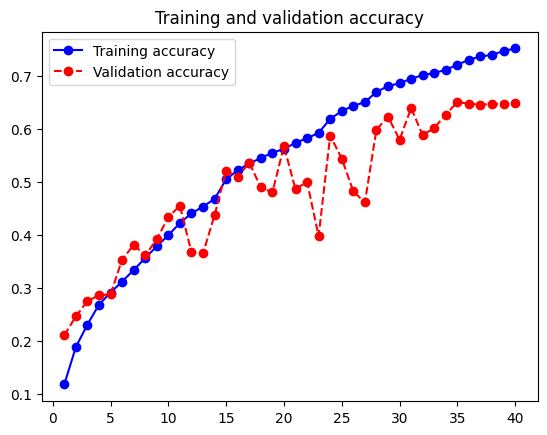

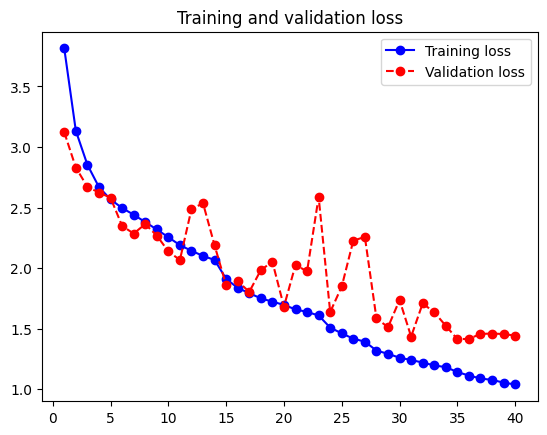

In [94]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history4 = model.fit(train_x, train_y,
                    epochs=50,
                    batch_size = 32,
                    validation_data=(val_x, val_y),
                     callbacks=[early_stopping, lr_scheduler])
plot(history4)
model.evaluate(test_x, test_y)

#### Inception blocks

In [63]:
def inception_block(x, filters, kernel_regularizer=None):
    f1, f3r, f3, f5r, f5, fpp = filters

    conv1x1 = layers.Conv2D(f1, (1, 1), activation='relu', padding='same', kernel_regularizer=kernel_regularizer)(x)

    conv3x3 = layers.Conv2D(f3r, (1, 1), activation='relu', padding='same', kernel_regularizer=kernel_regularizer)(x)
    conv3x3 = layers.Conv2D(f3, (3, 3), activation='relu', padding='same', kernel_regularizer=kernel_regularizer)(conv3x3)

    conv5x5 = layers.Conv2D(f5r, (1, 1), activation='relu', padding='same', kernel_regularizer=kernel_regularizer)(x)
    conv5x5 = layers.Conv2D(f5, (5, 5), activation='relu', padding='same', kernel_regularizer=kernel_regularizer)(conv5x5)

    pool_proj = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = layers.Conv2D(fpp, (1, 1), activation='relu', padding='same', kernel_regularizer=kernel_regularizer)(pool_proj)

    x = layers.Concatenate()([conv1x1, conv3x3, conv5x5, pool_proj])

    return x


input_layer = layers.Input(shape=(32, 32, 3))

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)

x = inception_block(x, [64, 128, 128, 32, 32, 32], kernel_regularizer=regularizers.l2(0.0002))


x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.4)(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0002))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

output_layer = layers.Dense(20, activation='softmax')(x)

model = models.Model(inputs=input_layer, outputs=output_layer)

model.summary()




Model: "functional_159"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_119 (Conv2D)       │ (None, 32, 32, 64)     │          1,792 │ input_layer_24[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_69          │ (None, 16, 16, 64)     │              0 │ conv2d_119[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_121 (Conv2D)       │ (None, 16, 16, 128)    │          8,320 │ max_pooling2d_69[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_123 (Conv2D)       │ (None, 16, 16, 32)     │          2,080 │ max_pooling2d_69[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_70          │ (None, 16, 16, 64)     │              0 │ max_pooling2d_69[0][0] │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_120 (Conv2D)       │ (None, 16, 16, 64)     │          4,160 │ max_pooling2d_69[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_122 (Conv2D)       │ (None, 16, 16, 128)    │        147,584 │ conv2d_121[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_124 (Conv2D)       │ (None, 16, 16, 32)     │         25,632 │ conv2d_123[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_125 (Conv2D)       │ (None, 16, 16, 32)     │          2,080 │ max_pooling2d_70[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 256)    │              0 │ conv2d_120[0][0],      │
│                           │                        │                │ conv2d_122[0][0],      │
│                           │                        │                │ conv2d_124[0][0],      │
│                           │                        │                │ conv2d_125[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_71          │ (None, 8, 8, 256)      │              0 │ concatenate[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_54 (Dropout)      │ (None, 8, 8, 256)      │              0 │ max_pooling2d_71[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 16384)          │              0 │ dropout_54[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_39 (Dense)          │ (None, 512)            │      8,389,120 │ flatten_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_171   │ (None, 512)            │          2,048 │ dense_39[0][0]         │
│ (BatchNormalization) 

 Total params: 8,593,076 (32.78 MB)

 Trainable params: 8,592,052 (32.78 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.3535 - loss: 2.1912 - val_accuracy: 0.4082 - val_loss: 2.0029 - learning_rate: 0.0010
Epoch 2/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3562 - loss: 2.1835 - val_accuracy: 0.4115 - val_loss: 2.0055 - learning_rate: 0.0010
Epoch 3/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3606 - loss: 2.1763 - val_accuracy: 0.4074 - val_loss: 2.0155 - learning_rate: 0.0010
Epoch 4/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3574 - loss: 2.1700 - val_accuracy: 0.4113 - val_loss: 1.9938 - learning_rate: 0.0010
Epoch 5/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3601 - loss: 2.1700 - val_accuracy: 0.3966 - val_loss: 2.0328 - learning_rate: 0.0010
Epoch 6/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3594 - loss: 2.1746 - val_accuracy: 0.4042 - val_loss: 2.0103 - learning_rate: 0.0010
Epoch 7/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.

[1.8172519207000732, 0.46470001339912415]

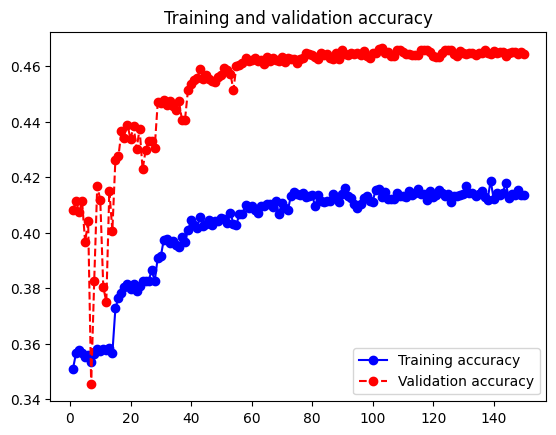

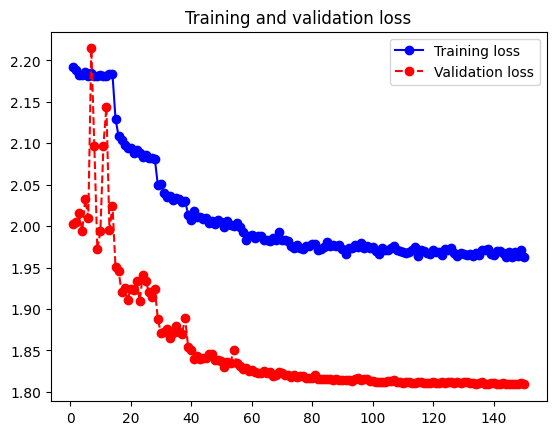

In [67]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history5 = model.fit(train_x, train_y,
                    epochs=150,
                    batch_size = 32,
                    validation_data=(val_x, val_y),
                     callbacks=[lr_scheduler, early_stopping])
plot(history5)
model.evaluate(test_x, test_y)

Epoch 1/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.4277 - loss: 1.9862 - val_accuracy: 0.4702 - val_loss: 1.8726 - learning_rate: 5.0000e-04
Epoch 2/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4291 - loss: 1.9623 - val_accuracy: 0.4677 - val_loss: 1.8671 - learning_rate: 5.0000e-04
Epoch 3/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4332 - loss: 1.9711 - val_accuracy: 0.4531 - val_loss: 1.9167 - learning_rate: 5.0000e-04
Epoch 4/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4362 - loss: 1.9700 - val_accuracy: 0.4676 - val_loss: 1.8611 - learning_rate: 5.0000e-04
Epoch 5/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4397 - loss: 1.9542 - val_accuracy: 0.4644 - val_loss: 1.8912 - learning_rate: 5.0000e-04
Epoch 6/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4375 - loss: 1.9482 - val_accuracy: 0.4652 - val_loss: 1.8753 - learning_rate: 5.0000e-04
Epoch 7/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s

[1.6469554901123047, 0.5195000171661377]

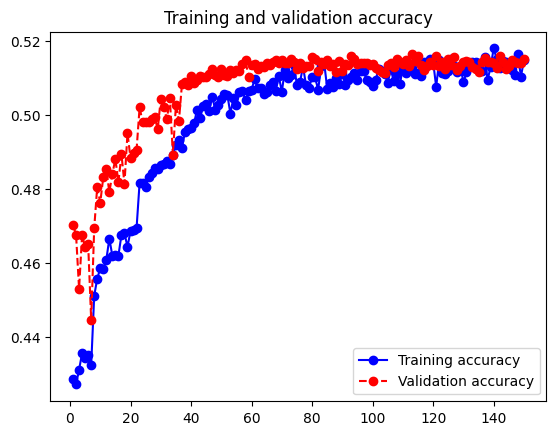

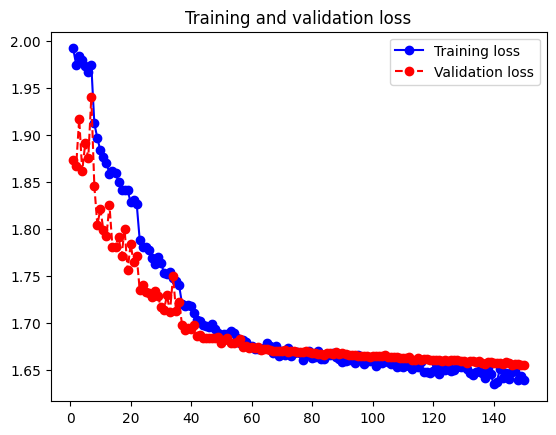

In [13]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history5 = model.fit(train_x, train_y,
                    epochs=150,
                    batch_size = 32,
                    validation_data=(val_x, val_y),
                     callbacks=[early_stopping, lr_scheduler])
plot(history5)
model.evaluate(test_x, test_y)

#### Xception network

In [58]:

inputs = keras.Input(shape=(32, 32, 3))


x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.2)(x)
x = layers.RandomZoom(0.2)(x)


x = layers.Rescaling(1./255)(x)


x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)


for size in [32, 64, 128, 256, 512]:
    residual = x
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)


    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)


    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])


x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.5)(x)

outputs = layers.Dense(20, activation="softmax")(x)


model = keras.Model(inputs=inputs, outputs=outputs)


model.summary()



Model: "functional_158"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_flip_3             │ (None, 32, 32, 3)      │              0 │ input_layer_23[0][0]   │
│ (RandomFlip)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_rotation_3         │ (None, 32, 32, 3)      │              0 │ random_flip_3[0][0]    │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_zoom_3             │ (None, 32, 32, 3)      │              0 │ random_rotation_3[0][… │
│ (RandomZoom)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_10 (Rescaling)  │ (None, 32, 32, 3)      │              0 │ random_zoom_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_113 (Conv2D)       │ (None, 28, 28, 32)     │          2,400 │ rescaling_10[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_161   │ (None, 28, 28, 32)     │            128 │ conv2d_113[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_52             │ (None, 28, 28, 32)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_80       │ (None, 28, 28, 32)     │          1,312 │ activation_52[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_162   │ (None, 28, 28, 32)     │            128 │ separable_conv2d_80[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_53             │ (None, 28, 28, 32)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_81       │ (None, 28, 28, 32)     │          1,312 │ activation_53[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_64          │ (None, 14, 14, 32)     │              0 │ separable_conv2d_81[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_114 (Conv2D)       │ (None, 14, 14, 32)     │          1,024 │ conv2d_113[0][0]       │
├──────────────────────

 Total params: 731,604 (2.79 MB)

 Trainable params: 728,596 (2.78 MB)

 Non-trainable params: 3,008 (11.75 KB)

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.3334 - loss: 2.1551 - val_accuracy: 0.2617 - val_loss: 2.4438 - learning_rate: 0.0010
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.3610 - loss: 2.0871 - val_accuracy: 0.0806 - val_loss: 4.9102 - learning_rate: 0.0010
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.3634 - loss: 2.0593 - val_accuracy: 0.2321 - val_loss: 2.8133 - learning_rate: 0.0010
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.3752 - loss: 2.0137 - val_accuracy: 0.3535 - val_loss: 2.1511 - learning_rate: 0.0010
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.3922 - loss: 1.9575 - val_accuracy: 0.3724 - val_loss: 2.0345 - learning_rate: 0.0010
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.4052 - loss: 1.9291 - val_accuracy: 0.1367 - val_loss: 3.3096 - learning_rate: 0.0010
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step -

[1.4893897771835327, 0.5444999933242798]

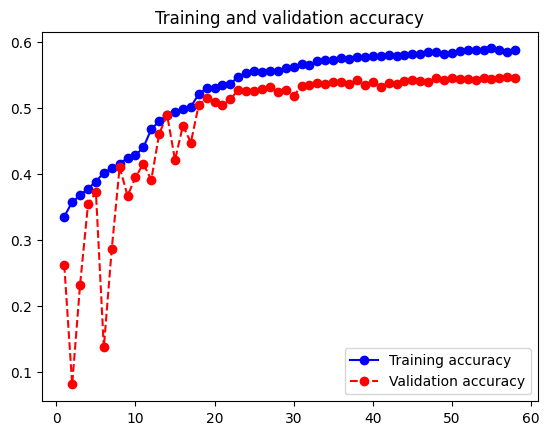

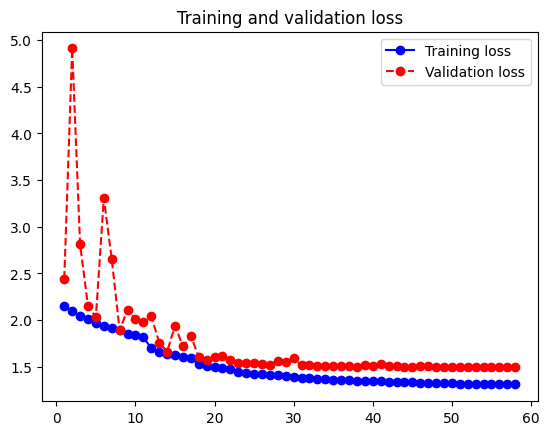

In [62]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history6 = model.fit(train_x, train_y,
                    epochs=100,
                    batch_size = 32,
                    validation_data=(val_x, val_y),
                     callbacks=[early_stopping, lr_scheduler])
plot(history6)
model.evaluate(test_x, test_y)

#### Conclusions

<ipython-input-70-b9d839e38d45>:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


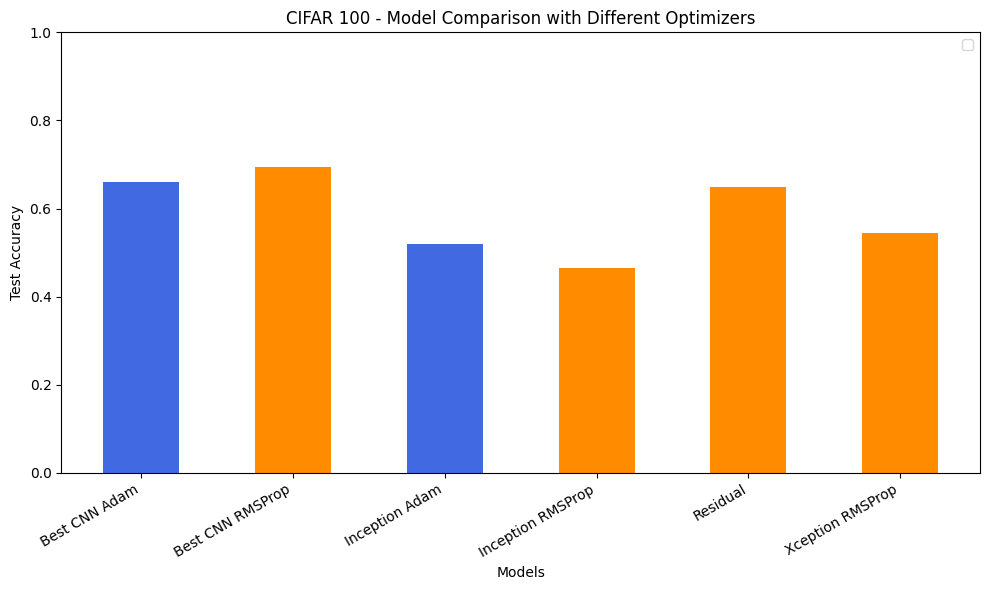

In [70]:
models = [
    "Best CNN Adam",
    "Best CNN RMSProp",
    "Inception Adam",
    "Inception RMSProp",
    "Residual",
    "Xception RMSProp"
]

test_accuracies = [0.6613, 0.6944, 0.5195, 0.46470, 0.6485, 0.5444]


colors = ['royalblue' if 'Adam' in model else 'darkorange' for model in models]


x = np.arange(len(models))
width = 0.5
fig, ax = plt.subplots(figsize=(10, 6))


ax.bar(x, test_accuracies, width, color=colors)


ax.set_xlabel("Models")
ax.set_ylabel("Test Accuracy")
ax.set_title("CIFAR 100 - Model Comparison with Different Optimizers")

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=30, ha="right")

ax.set_ylim(0, 1)

ax.legend()

plt.tight_layout()
plt.show()



among the architectures, the best CNN performs the best with an accuracy of 0.6613, followed by Residual, which achieves an accuracy of 0.6485. Inception shows lower performance, reaching 0.5195, and Xception achieves an accuracy of 0.5444. The results indicate that the Best CNN and Residual architectures are more effective in this case, while Inception and Xception show relatively lower performance. Although the optimizer plays a role in model performance, these architectures' inherent design and complexity appear to have a more significant impact on the final results.

### Helper functions: Plotting and tuning

In [11]:
import matplotlib.pyplot as plt

def plot(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, "b-o", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "r--o", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, "b-o", label="Training loss")
    plt.plot(epochs, val_loss, "r--o", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()

In [ ]:
import keras_tuner as kt

# Function to build the model
def build_model(hp):
    model = keras.Sequential()

    model.add(layers.Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(hp.Float('l2_1', 1e-4, 1e-2, sampling='log')),
        input_shape=(32, 32, 3)
    ))
    model.add(layers.BatchNormalization())

    # Number of Conv Layers (3, 5, or 6)
    for i in range(hp.Choice('num_conv_layers', [3, 5, 6])):
        model.add(layers.Conv2D(
            filters=hp.Int(f'filters_{i+2}', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice(f'kernel_size_{i+2}', values=[3, 5]),
            activation='relu',
            padding='same',
            kernel_regularizer=regularizers.l2(hp.Float(f'l2_{i+2}', 1e-4, 1e-2, sampling='log'))
        ))
        model.add(layers.BatchNormalization())

        # Apply MaxPooling only if dimensions allow it
        if model.output_shape[1] > 2 and model.output_shape[2] > 2:
            model.add(layers.MaxPooling2D((2, 2)))

        model.add(layers.Dropout(rate=hp.Float(f'dropout_{i+2}', 0.2, 0.5, step=0.1)))

    model.add(layers.Flatten())

    # We add dense Layers for generalization
    for j in range(hp.Int('num_dense_layers', 1, 3)):  # 1 to 3 dense layers aprox
        model.add(layers.Dense(
            units=hp.Int(f'dense_units_{j+1}', min_value=128, max_value=512, step=128),
            activation='relu',
            kernel_regularizer=regularizers.l2(hp.Float(f'l2_dense_{j+1}', 1e-4, 1e-2, sampling='log'))
        ))
        model.add(layers.Dropout(rate=hp.Float(f'dense_dropout_{j+1}', 0.2, 0.5, step=0.1)))

    model.add(layers.Dense(20, activation='softmax'))

    # Optimizer and learning rate (we will do manual tests also)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    model.compile(
        optimizer=keras.optimizers.get({"class_name": optimizer, "config": {"learning_rate": learning_rate}}),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

# Define keras tuner
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=20,
    factor=3,
    directory="hyperband_tuning",
    project_name="cnn_tuning"
)


# Train model with early stopping because of overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

tuner.search(train_x, train_y, validation_data=(val_x, val_y), epochs=20, callbacks=[early_stopping])

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

# Save the best model
best_model.save("best_model.h5")